# LSTM 

In [1]:
# 패키지 로드
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
# 데이터 로드 및 전처리
df = pd.read_csv('전체데이터_병합.csv',encoding='cp949')
df.head()

,y_m,city,location,area_cnt,em_cnt,em_g,pay_amt,제주도민_여,외국인거주_여,제주도민_남,...,기온,습도,강수,전국_누적확진자,전국_월별확진자,제주_누적확진자,제주_월별확진자,visit_pop_cnt,visit_pop_cnt_lf,visit_pop_cnt_sf
0,2018-01,서귀포시,남원읍,52.0,9570,42437700,1270773,9306.0,200.0,9806.0,...,6.256586,62.920699,1.891667,0.0,0.0,0.0,0.0,7650.915819,469.700347,1686.010590
1,2018-01,서귀포시,대륜동,38.0,21666,57612600,1676850,6637.0,95.0,6836.0,...,8.004301,66.793011,2.958333,0.0,0.0,0.0,0.0,7964.610507,371.723546,420.833558
2,2018-01,서귀포시,대정읍,89.0,10185,38885550,1164122,10725.0,677.0,10360.0,...,5.417876,70.940860,1.870833,0.0,0.0,0.0,0.0,4994.300798,410.511223,356.262995
3,2018-01,서귀포시,대천동,37.0,20280,53858550,1593709,6475.0,137.0,6685.0,...,8.004301,66.793011,2.958333,0.0,0.0,0.0,0.0,4671.393555,234.238089,225.574534
4,2018-01,서귀포시,동홍동,49.0,45936,118701000,3501286,11569.0,642.0,11124.0,...,5.771505,69.944892,3.812500,0.0,0.0,0.0,0.0,3881.022202,270.258431,353.699388


In [3]:
# 필요없는 열 삭제
df = df.drop(columns=['city','location','식당_결제금액','간식_결제금액','패스트푸드_결제금액','마트/슈퍼마켓_결제금액','배달_결제금액','농축수산물_결제금액'], axis=1)

In [4]:
# 날짜 열 이름 재설정
df = df.rename(columns={'y_m':'date'})

In [5]:
# 시계열 datetime으로 변경
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace = True)

In [6]:
# 행 추출
lag_col = list(df.columns)

In [7]:
# 시계열 변수 설정
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
df.dropna(inplace=True)
df

,area_cnt,em_cnt,em_g,pay_amt,제주도민_여,외국인거주_여,제주도민_남,외국인거주_남,제주도민_60이상,제주도민_60미만,...,제주_월별확진자_lag3,visit_pop_cnt_lag1,visit_pop_cnt_lag2,visit_pop_cnt_lag3,visit_pop_cnt_lf_lag1,visit_pop_cnt_lf_lag2,visit_pop_cnt_lf_lag3,visit_pop_cnt_sf_lag1,visit_pop_cnt_sf_lag2,visit_pop_cnt_sf_lag3
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,37.0,20280,53858550,1593709,6475.0,137.0,6685.0,107.0,2372.0,11032.0,...,0.0,4994.300798,7964.610507,7650.915819,410.511223,371.723546,469.700347,356.262995,420.833558,1686.010590
2018-01-01,49.0,45936,118701000,3501286,11569.0,642.0,11124.0,624.0,3898.0,20061.0,...,0.0,4671.393555,4994.300798,7964.610507,234.238089,410.511223,371.723546,225.574534,356.262995,420.833558
2018-01-01,24.0,15597,47230450,1397423,5335.0,66.0,5302.0,61.0,1857.0,8907.0,...,0.0,3881.022202,4671.393555,4994.300798,270.258431,234.238089,410.511223,353.699388,225.574534,356.262995
2018-01-01,74.0,2456,11343100,339679,7332.0,560.0,8006.0,1015.0,4642.0,12271.0,...,0.0,1671.296219,3881.022202,4671.393555,426.873915,270.258431,234.238089,1355.525718,353.699388,225.574534
2018-01-01,20.0,6039,22834700,666988,2111.0,157.0,2344.0,366.0,1298.0,3680.0,...,0.0,11249.047472,1671.296219,3881.022202,618.543156,426.873915,270.258431,785.533219,1355.525718,353.699388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,87.0,84360,147438200,4402149,16569.0,200.0,16077.0,75.0,7786.0,25135.0,...,234.0,1033.436663,1986.539002,6100.024428,177.789332,218.594870,261.972586,6.572199,11.693123,24.062756
2021-06-01,141.0,27732,63927750,1911187,12422.0,242.0,13017.0,279.0,6788.0,19172.0,...,234.0,2601.794246,1033.436663,1986.539002,210.270986,177.789332,218.594870,11.877085,6.572199,11.693123
2021-06-01,71.0,8031,27060150,809898,4531.0,100.0,4627.0,237.0,3440.0,6055.0,...,234.0,13478.916454,2601.794246,1033.436663,377.112397,210.270986,177.789332,30.738787,11.877085,6.572199


In [8]:
# 결측치 확인
df.isnull().sum().sum()

0

In [9]:
# 데이터 프레임 형태 확인
print("전체데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['em_g'].shape))

전체데이터 shape: (1663, 120)
target feature shape: (1663,)


In [10]:
x_cols = list(df.columns)
x_cols.remove('em_g')

In [13]:
# 테스트 데이터 수
test_data_size = 84
# X변수들과 y변수 구분
X = df[x_cols]
y = df['em_g']

In [15]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.fit_transform(X)
y = yscaler.fit_transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [16]:
print("train set : ",X_train.shape)
print("test set : ",X_test.shape)

train set :  (1579, 119)
test set :  (84, 119)


In [17]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length ==1:
        for i in range(len(array)):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
    return res

In [18]:
# sequence 형식으로 불러오기
seq_length = 1

X_train = create_sequences1(X_train,seq_length)
y_train = create_sequences1(y_train,seq_length)
X_test = create_sequences1(X_test,seq_length)
y_test = create_sequences1(y_test,seq_length)

In [19]:
# tensor로 불러오기
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [20]:
print("X_traint : ",(X_train.shape))
print("X_testt : ",X_test.shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)

X_traint :  torch.Size([1579, 1, 119])
X_testt :  torch.Size([84, 1, 119])
y_train :  torch.Size([1579, 1])
y_test :  torch.Size([84, 1])


In [21]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

In [22]:
# 훈련 모델 정의
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [23]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=200

In [24]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.0946 test loss: 0.088
Epoch 10 train loss: 0.0794 test loss: 0.0722
Epoch 20 train loss: 0.0651 test loss: 0.0572
Epoch 30 train loss: 0.0514 test loss: 0.0428
Epoch 40 train loss: 0.0392 test loss: 0.0304
Epoch 50 train loss: 0.0329 test loss: 0.0258
Epoch 60 train loss: 0.0335 test loss: 0.028
Epoch 70 train loss: 0.0328 test loss: 0.0261
Epoch 80 train loss: 0.0328 test loss: 0.0257
Epoch 90 train loss: 0.0327 test loss: 0.0257
Epoch 100 train loss: 0.0326 test loss: 0.0257
Epoch 110 train loss: 0.0326 test loss: 0.0257
Epoch 120 train loss: 0.0326 test loss: 0.0256
Epoch 130 train loss: 0.0326 test loss: 0.0256
Epoch 140 train loss: 0.0325 test loss: 0.0256
Epoch 150 train loss: 0.0325 test loss: 0.0255
Epoch 160 train loss: 0.0325 test loss: 0.0255
Epoch 170 train loss: 0.0324 test loss: 0.0255
Epoch 180 train loss: 0.0324 test loss: 0.0255
Epoch 190 train loss: 0.0323 test loss: 0.0254


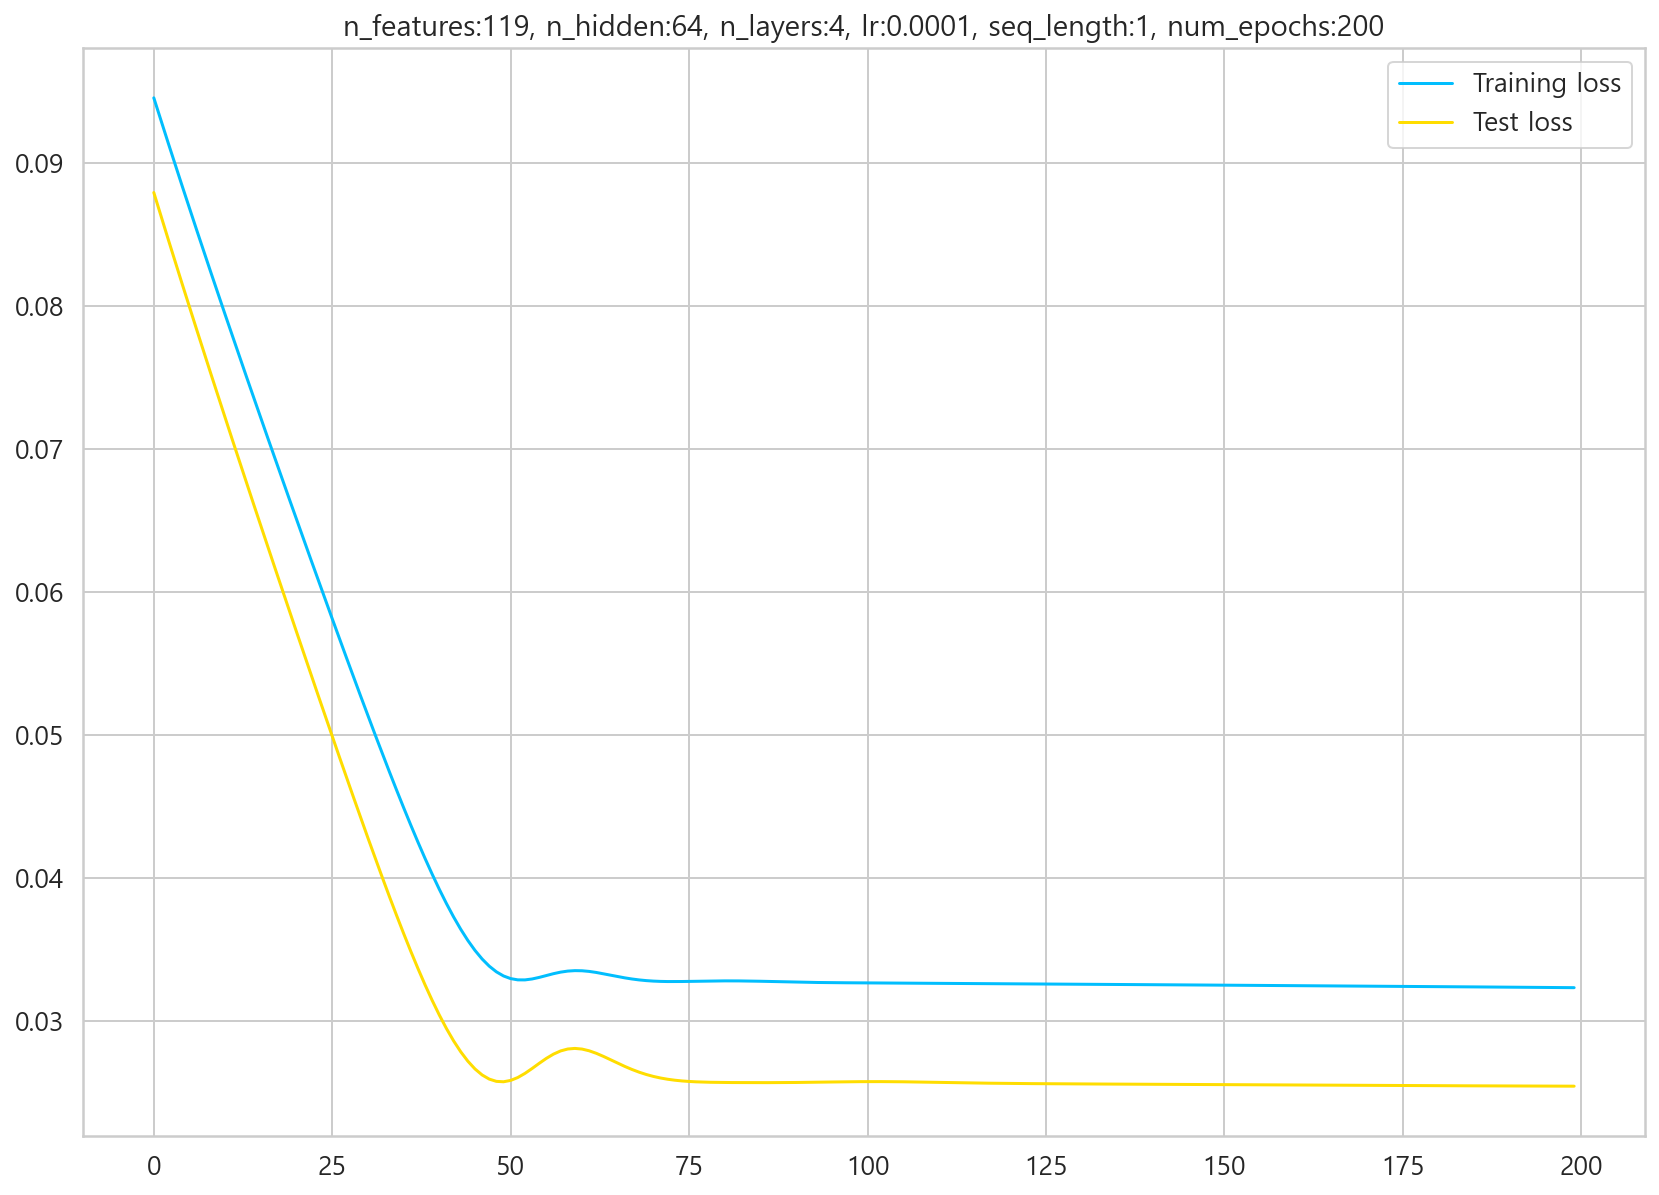

In [25]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()
# plt.savefig('lstm.png')

In [26]:
# 예측

with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [27]:
preds

[0.200434148311615,
 0.19999772310256958,
 0.19962868094444275,
 0.19884774088859558,
 0.19805863499641418,
 0.19706273078918457,
 0.19593828916549683,
 0.19421160221099854,
 0.19201982021331787,
 0.18929171562194824,
 0.18614929914474487,
 0.18281230330467224,
 0.1796482801437378,
 0.17668429017066956,
 0.17406100034713745,
 0.17199769616127014,
 0.1703113615512848,
 0.16878214478492737,
 0.16750183701515198,
 0.16651076078414917,
 0.16751635074615479,
 0.1701168417930603,
 0.1738908886909485,
 0.17788028717041016,
 0.18091174960136414,
 0.18323644995689392,
 0.18571168184280396,
 0.1889154016971588,
 0.19337913393974304,
 0.19841358065605164,
 0.20333245396614075,
 0.20690923929214478,
 0.2086467146873474,
 0.20840400457382202,
 0.20781537890434265,
 0.2068682312965393,
 0.20555919408798218,
 0.2045682668685913,
 0.20373818278312683,
 0.20280611515045166,
 0.20207053422927856,
 0.20135751366615295,
 0.20068702101707458,
 0.1998070776462555,
 0.1990240514278412,
 0.19798383116722107,


In [28]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [29]:
pred_values

array([[65908859.94867384],
       [65766085.12177169],
       [65645354.40055281],
       [65389872.86790162],
       [65131719.91333216],
       [64805913.68616819],
       [64438056.938079  ],
       [63873177.94865966],
       [63156144.90647912],
       [62263655.99261522],
       [61235626.54040158],
       [60143941.1987558 ],
       [59108843.20314527],
       [58139185.29481739],
       [57280986.12871468],
       [56605984.10802931],
       [56054306.23276085],
       [55554028.85513157],
       [55135181.09743446],
       [54810954.32410538],
       [55139929.20865417],
       [55990669.84275877],
       [57225334.75532234],
       [58530451.10869408],
       [59522182.37185031],
       [60282699.14306551],
       [61092461.72489822],
       [62140546.34092897],
       [63600839.15872127],
       [65247839.01934177],
       [66857029.48507518],
       [68027161.03385389],
       [68595569.42011416],
       [68516167.74090827],
       [68323601.11934692],
       [68013745.425

In [30]:
pred_values_ceiled  = list(pred_values.flatten())

In [31]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [32]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [33]:
score_table

,True,Pred
0,5.981660e+07,6.590886e+07
1,4.610435e+07,6.576609e+07
2,1.139298e+08,6.564535e+07
3,5.834155e+07,6.538987e+07
4,9.402740e+07,6.513172e+07
...,...,...
79,1.474382e+08,6.709640e+07
80,6.392775e+07,6.680872e+07
81,2.706015e+07,6.648161e+07
82,8.274699e+07,6.622482e+07


In [34]:
# validation score , score = MSE와 RMSE의 차이, 100에 가까울수록 좋음
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [35]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 2719885139016778.5, RMSE : 52152518.05058677, SCORE : 60.88229890249901


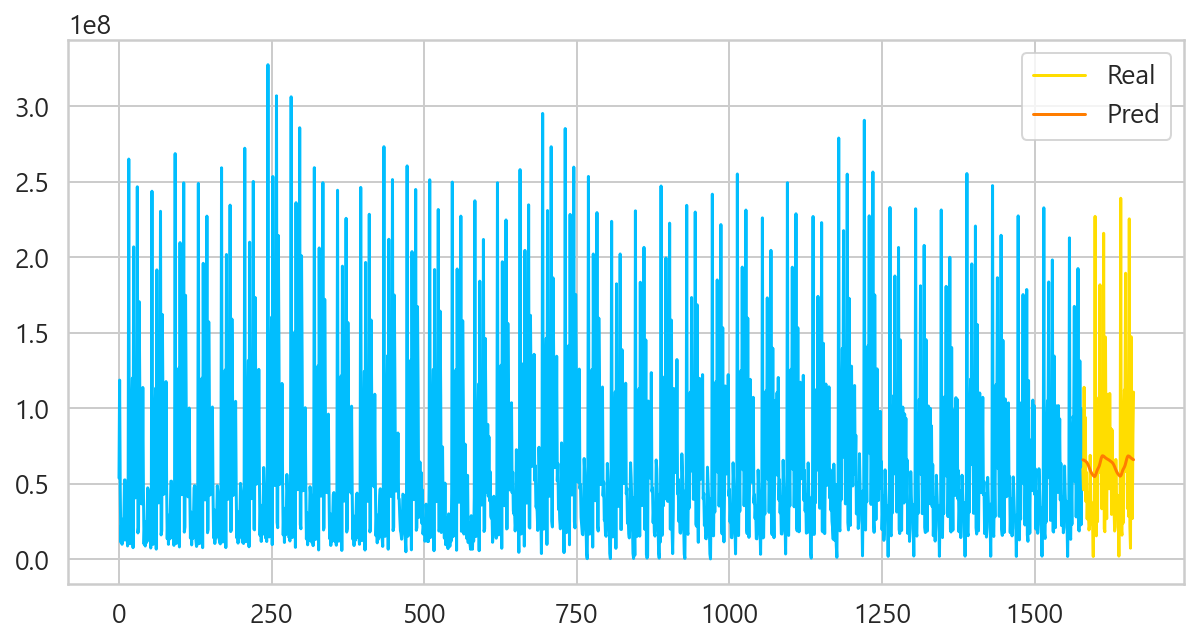

In [36]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
plt.legend()
plt.savefig('pred_lstm_ap.png')

### 전체데이터 사용해서 예측

In [37]:
# X변수들과 y변수 구분
X_all = df[x_cols]
y_all = df['em_g']

In [38]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.fit_transform(X_all)
y_all = yscaler.fit_transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [39]:
y_all

array([0.16359951, 0.36180588, 0.14333915, ..., 0.08168383, 0.2519039 ,
       0.33750191])

In [40]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (1663, 119)
y_all :  (1663,)


In [41]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [42]:
DAYS_TO_PREDICT = 60
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]

In [43]:
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [44]:
# 예측값 반올림
import math

pred_values_ceiled = list(pred_values.flatten())
predicted_cases=pred_values_ceiled
predicted_cases

[65661421.93092257,
 65202093.3564201,
 64646164.605398476,
 64044782.68290609,
 63449991.56777412,
 62901560.34761071,
 62422888.33848834,
 62022857.53079951,
 61699888.470709324,
 61446278.883343935,
 61251538.07533085,
 61104746.36583626,
 60995764.05122876,
 60915884.63598639,
 60857961.57899201,
 60816349.795243144,
 60786700.911836326,
 60765729.27480638,
 60750997.45539576,
 60740711.506038904,
 60733555.21520674,
 60728631.609116495,
 60725238.70828599,
 60722898.77667874,
 60721338.82227391,
 60720246.85419053,
 60719525.375278294,
 60719037.889526784,
 60718696.64950073,
 60718482.15577006,
 60718335.91004461,
 60718248.16260934,
 60718179.91460413,
 60718140.91574401,
 60718101.916883886,
 60718092.167168856,
 60718072.667738795,
 60718072.667738795,
 60718062.918023765,
 60718062.918023765,
 60718062.918023765,
 60718053.168308735,
 60718053.168308735,
 60718053.168308735,
 60718053.168308735,
 60718053.168308735,
 60718053.168308735,
 60718053.168308735,
 60718053.16830873

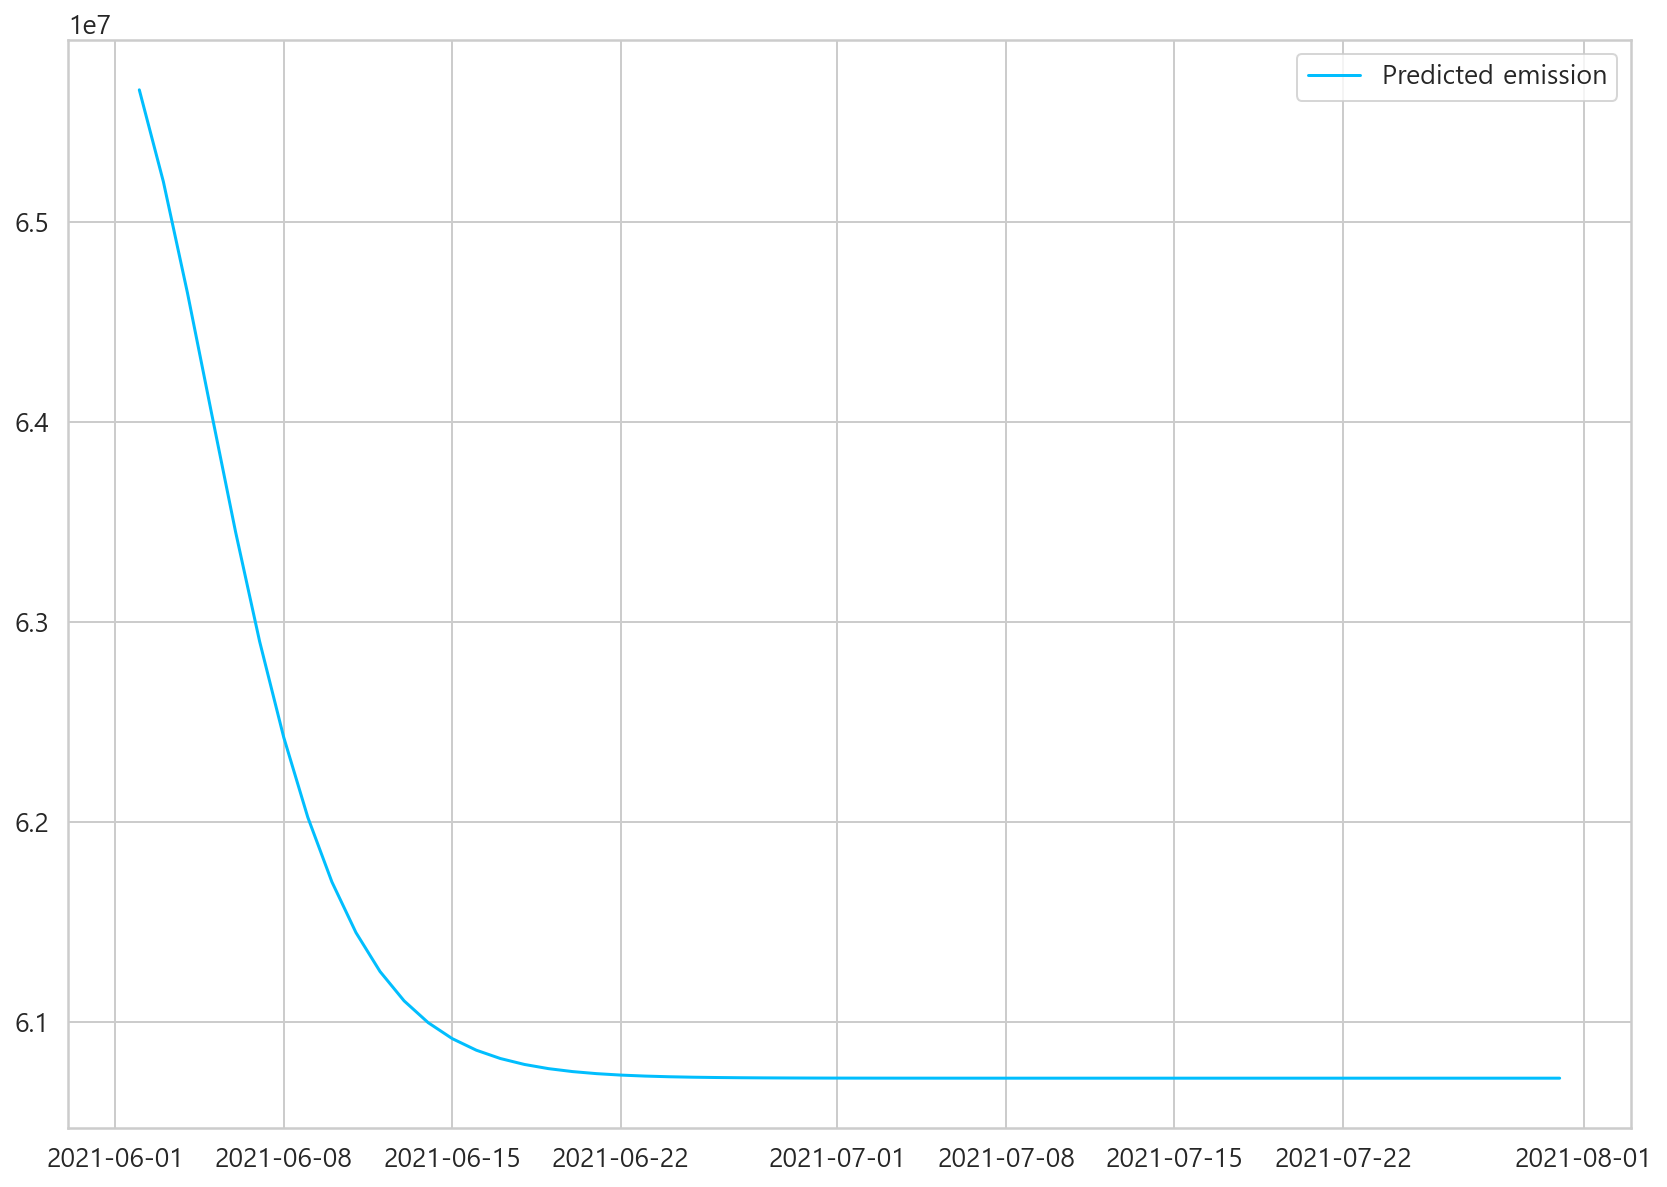

In [45]:
# 예측값
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted emission')
plt.legend()
plt.savefig('pred_lstm.png')

In [46]:
# 예측값 데이터프레임 형태로 변형
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [47]:
# 예측값
preds_

,0
2021-06-02,6.566142e+07
2021-06-03,6.520209e+07
2021-06-04,6.464616e+07
2021-06-05,6.404478e+07
2021-06-06,6.344999e+07
2021-06-07,6.290156e+07
2021-06-08,6.242289e+07
2021-06-09,6.202286e+07
2021-06-10,6.169989e+07
2021-06-11,6.144628e+07


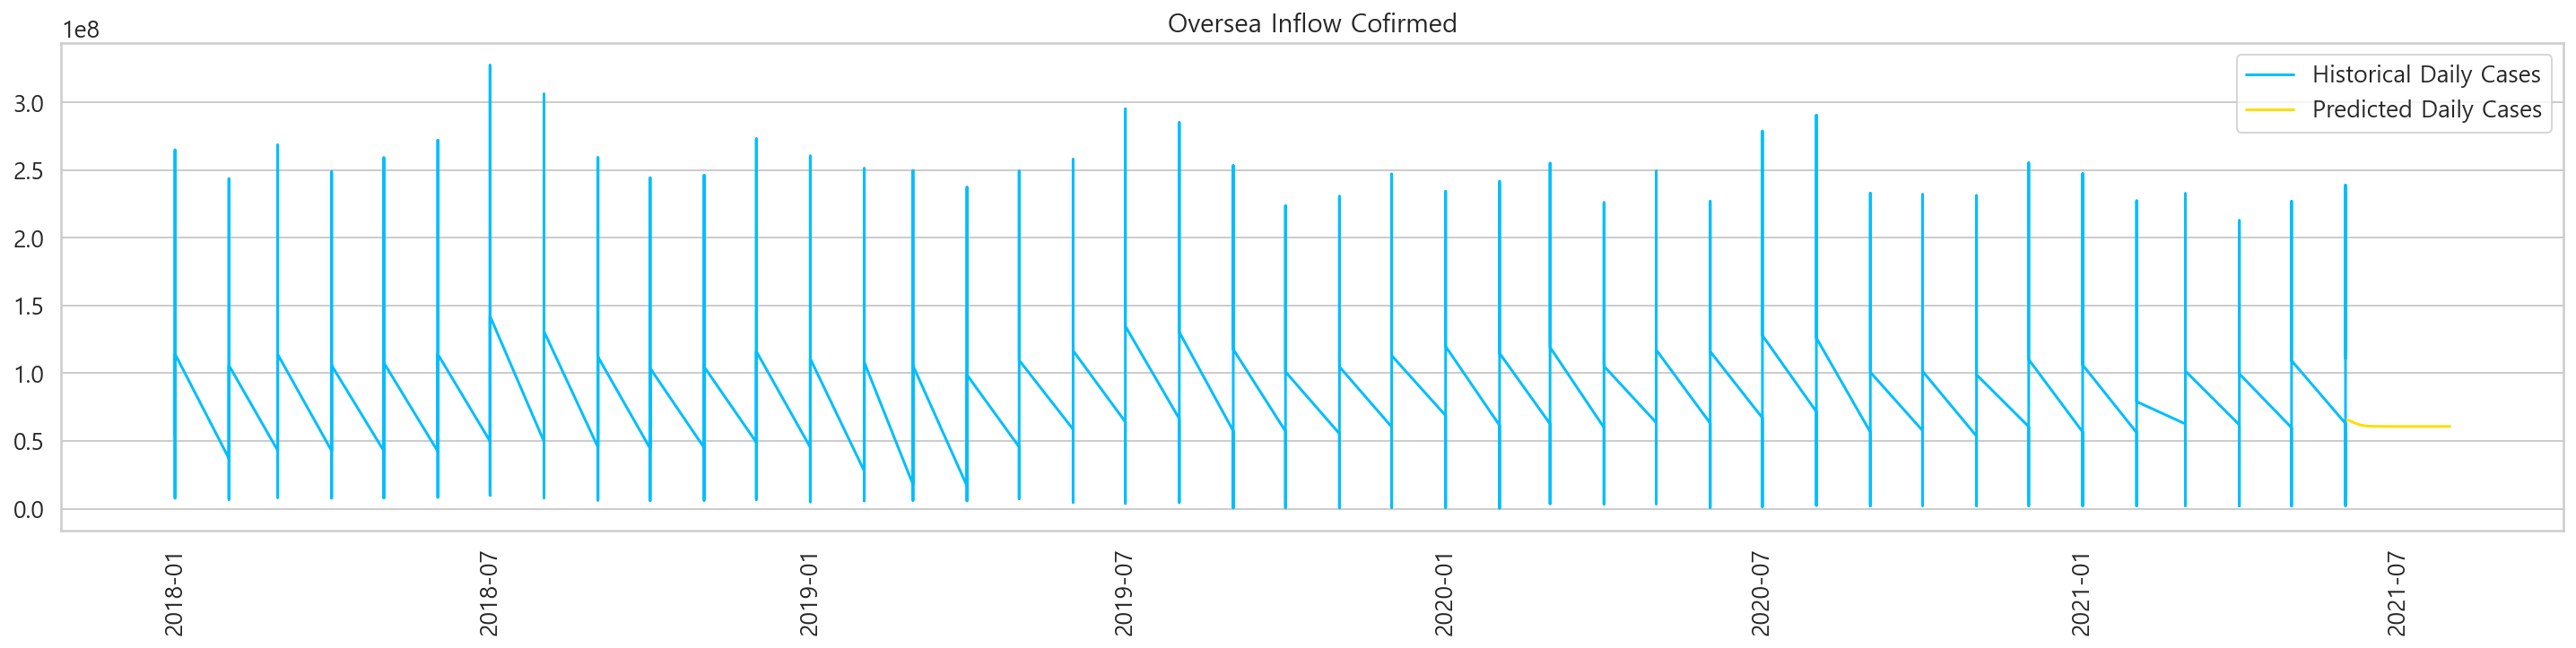

In [48]:
# 그래프로 시각화
plt.figure(figsize=(25,5))
plt.plot(df['em_g'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();